In [8]:
# We will start by fixing the seed for reproducibility
seed = 0
import torch
torch.manual_seed(seed)
import numpy as np
np.random.seed(seed)
import random
random.seed(seed)

In [9]:
try:
    import pgmuvi
except ImportError:
    %pip install git+https://github.com/ICSM/pgmuvi.git
    import pgmuvi

In [10]:
try:
    import astropy
except ImportError:
    %pip install astropy
    import astropy

In [11]:
from astropy.table import Table
from pathlib import Path
p = Path('C:/Users/peter/Downloads/lightcurve_2d.vot')
table = Table.read(p, format='votable')

In [12]:
import gpytorch

In [13]:
x, y, yerr = table['x'].value, table['y'].value, table['yerr'].value

In [14]:
# print(x.min(dim=0), x.max(dim=0), y.min(), y.max())

In [15]:
print(x.shape, y.shape, yerr.shape)

(1, 2, 1354) (1, 1354) (1, 1354)


In [16]:
print(x[0, 1])

[564.364501953125 3.5453460216522217 567.3599853515625 ...
 4.886754989624023 1162.0 4.886754989624023]


In [17]:
# looks like we need to unroll x - each pair of values is a time and a wavelength but they are not separated into different columns
x = x.reshape(-1, 2)
print(x.shape)
print(x)

(1354, 2)
[[0.0 0.4783500134944916]
 [2.99242901802063 0.4783500134944916]
 [6.071380138397217 0.4783500134944916]
 [23.005996704101562 0.4783500134944916]
 [27.02593994140625 0.4783500134944916]
 [29.982131958007812 0.4783500134944916]
 [30.03873634338379 0.4783500134944916]
 [33.01871871948242 0.4783500134944916]
 [43.001182556152344 0.4783500134944916]
 [126.31314849853516 0.4783500134944916]
 [132.3157196044922 0.4783500134944916]
 [141.271240234375 0.4783500134944916]
 [144.3118438720703 0.4783500134944916]
 [147.29676818847656 0.4783500134944916]
 [156.2979736328125 0.4783500134944916]
 [159.33763122558594 0.4783500134944916]
 [162.29273986816406 0.4783500134944916]
 [165.3170928955078 0.4783500134944916]
 [168.2939910888672 0.4783500134944916]
 [171.29266357421875 0.4783500134944916]
 [174.31639099121094 0.4783500134944916]
 [178.29591369628906 0.4783500134944916]
 [180.21141052246094 0.4783500134944916]
 [181.31422424316406 0.4783500134944916]
 [184.25823974609375 0.47835001349

[]

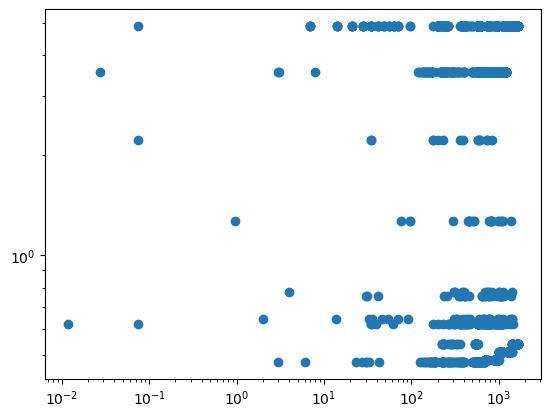

In [18]:
import matplotlib.pyplot as plt
plt.plot(x[:,0], x[:,1], 'o')
plt.loglog()

In [19]:
# now we can turn these into inputs for the model
t = x[:,0]
w = x[:,1]
x = torch.stack([torch.tensor(t), torch.tensor(w)], 0).T
print(x.shape)
y = torch.tensor(y)
yerr = torch.tensor(yerr)
print(torch.isnan(yerr).sum())
nans = torch.isnan(yerr)
print(nans.sum())
x = x[~nans.flatten()]
y = y[~nans]
yerr = yerr[~nans]
x.shape, y.shape, yerr.shape

torch.Size([1354, 2])
tensor(66)
tensor(66)


(torch.Size([1288, 2]), torch.Size([1288]), torch.Size([1288]))

In [20]:
from pgmuvi.lightcurve import Lightcurve
lightcurve2d = Lightcurve(x, y, yerr=yerr, transform='minmax')

In [21]:
if torch.cuda.is_available():
    print('Using GPU')
    lightcurve2d = lightcurve2d.cuda()

In [22]:
from pgmuvi.gps import SpectralMixtureTimesRBFGPModel

In [23]:
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=yerr,
                                                               learn_additional_noise=True)
model = SpectralMixtureTimesRBFGPModel(lightcurve2d._xdata_transformed,
                                       lightcurve2d._ydata_transformed, likelihood,
                                       num_mixtures=1)

kernels.0.kernels.0.raw_outputscale Parameter containing:
tensor(0., requires_grad=True)
kernels.0.kernels.0.base_kernel.raw_mixture_weights Parameter containing:
tensor([0.], requires_grad=True)
kernels.0.kernels.0.base_kernel.raw_mixture_means Parameter containing:
tensor([[[0.]]], requires_grad=True)
kernels.0.kernels.0.base_kernel.raw_mixture_scales Parameter containing:
tensor([[[0.]]], requires_grad=True)
kernels.0.kernels.1.raw_outputscale Parameter containing:
tensor(0., requires_grad=True)
kernels.0.kernels.1.base_kernel.raw_lengthscale Parameter containing:
tensor([[0.]], requires_grad=True)
kernels.1.raw_outputscale Parameter containing:
tensor(0., requires_grad=True)
kernels.1.base_kernel.raw_lengthscale Parameter containing:
tensor([[0., 0.]], requires_grad=True)


In [30]:
for name, param in model.named_parameters():
    print(f'{name}: {param}, {param.shape}')

likelihood.second_noise_covar.raw_noise: Parameter containing:
tensor([0.], requires_grad=True), torch.Size([1])
mean_module.raw_constant: Parameter containing:
tensor(11.7063, requires_grad=True), torch.Size([])
covar_module.kernels.0.kernels.0.raw_outputscale: Parameter containing:
tensor(0., requires_grad=True), torch.Size([])
covar_module.kernels.0.kernels.0.base_kernel.raw_mixture_weights: Parameter containing:
tensor([0.], requires_grad=True), torch.Size([1])
covar_module.kernels.0.kernels.0.base_kernel.raw_mixture_means: Parameter containing:
tensor([[[0.]]], requires_grad=True), torch.Size([1, 1, 1])
covar_module.kernels.0.kernels.0.base_kernel.raw_mixture_scales: Parameter containing:
tensor([[[0.]]], requires_grad=True), torch.Size([1, 1, 1])
covar_module.kernels.0.kernels.1.raw_outputscale: Parameter containing:
tensor(0., requires_grad=True), torch.Size([])
covar_module.kernels.0.kernels.1.base_kernel.raw_lengthscale: Parameter containing:
tensor([[-2.2522]], requires_grad=

In [27]:
lightcurve2d.set_likelihood(likelihood)
lightcurve2d.set_model(model)

In [33]:
# Add initial guesses for some hyperparameters
hypers = {
    'mean_module.constant': y.mean(),
    'covar_module.kernels.1.base_kernel.lengthscale': torch.tensor([[0.1, 0.1]]), 
    'covar_module.kernels.0.kernels.1.base_kernel.lengthscale': torch.tensor([[0.1]]),
    'covar_module.kernels.0.kernels.0.base_kernel.mixture_means': torch.tensor([[[0.01]]]),
}
for key, value in hypers.items():
    print(key, value.shape)
lightcurve2d.set_hypers(hypers=hypers)

mean_module.constant torch.Size([])
covar_module.kernels.1.base_kernel.lengthscale torch.Size([1, 2])
covar_module.kernels.0.kernels.1.base_kernel.lengthscale torch.Size([1, 1])
covar_module.kernels.0.kernels.0.base_kernel.mixture_means torch.Size([1, 1, 1])


RuntimeError: shape '[1, 1, 1]' is invalid for input of size 2

In [21]:
lightcurve2d.fit(training_iter=30) #, likelihood='learn')

are not yet implemented for 2D data
PLEASE SET CONSTRAINTS MANUALLY
likelihood.second_noise_covar.noise: tensor([2.4407])
mean_module.constant: 15.7369966506958
covar_module.kernels.0.kernels.0.outputscale: 2.544405460357666
covar_module.kernels.0.kernels.0.base_kernel.mixture_weights: tensor([2.5443])
covar_module.kernels.0.kernels.0.base_kernel.mixture_means: tensor([[[0.0015, 0.5821]]])
covar_module.kernels.0.kernels.0.base_kernel.mixture_scales: tensor([[[0.0016, 0.6137]]])
covar_module.kernels.0.kernels.1.outputscale: 2.5445716381073
covar_module.kernels.0.kernels.1.base_kernel.lengthscale: tensor([[0.0767]])
covar_module.kernels.1.outputscale: 2.094672441482544
covar_module.kernels.1.base_kernel.lengthscale: tensor([[0.3075, 0.1192]])


100%|██████████| 100/100 [07:04<00:00,  4.25s/it]


{'loss': [array(19.539879, dtype=float32),
  array(19.036085, dtype=float32),
  array(18.525225, dtype=float32),
  array(17.86246, dtype=float32),
  array(17.315369, dtype=float32),
  array(16.83259, dtype=float32),
  array(16.342989, dtype=float32),
  array(15.962475, dtype=float32),
  array(15.649487, dtype=float32),
  array(15.361971, dtype=float32),
  array(15.0297365, dtype=float32),
  array(14.775663, dtype=float32),
  array(14.49401, dtype=float32),
  array(14.316879, dtype=float32),
  array(14.085231, dtype=float32),
  array(14.010593, dtype=float32),
  array(13.868452, dtype=float32),
  array(13.6803, dtype=float32),
  array(13.553672, dtype=float32),
  array(13.519858, dtype=float32),
  array(13.5015135, dtype=float32),
  array(13.287546, dtype=float32),
  array(13.241735, dtype=float32),
  array(13.109809, dtype=float32),
  array(12.935305, dtype=float32),
  array(12.986271, dtype=float32),
  array(12.791916, dtype=float32),
  array(12.786436, dtype=float32),
  array(12.9214

In [17]:
'mean_module.constant' in lightcurve2d._model_pars

True

In [34]:
lightcurve2d._xdata_transformed

tensor([[0.0000, 0.0000],
        [0.0018, 0.0000],
        [0.0036, 0.0000],
        ...,
        [0.6813, 1.0000],
        [0.6854, 1.0000],
        [0.6896, 1.0000]])

In [22]:
lightcurve2d.print_results()

loss: [11.293553]
delta_loss: [0.00646687]
likelihood.second_noise_covar.noise: [2.4407084]
mean_module.constant: [13.582596]
covar_module.kernels.0.kernels.0.outputscale: [5.24171]
covar_module.kernels.0.kernels.0.base_kernel.mixture_weights: [5.2364726]
covar_module.kernels.0.kernels.0.base_kernel.mixture_means: [0.00419672 1.604176  ]
covar_module.kernels.0.kernels.0.base_kernel.mixture_scales: [0.00419351 1.6029495 ]
covar_module.kernels.0.kernels.1.outputscale: [5.226322]
covar_module.kernels.0.kernels.1.base_kernel.lengthscale: [0.03121711]
covar_module.kernels.1.outputscale: [0.94325745]
covar_module.kernels.1.base_kernel.lengthscale: [0.7244576 0.2390247]


In [19]:
lightcurve2d.print_periods()

AttributeError: 'AdditiveKernel' object has no attribute 'mixture_means'

In [24]:
lightcurve2d.plot_psd()

NotImplementedError: Plotting PSDs in more than 1 dimension is
                                          not currently supported. Please get in touch
                                          if you need this functionality!
                

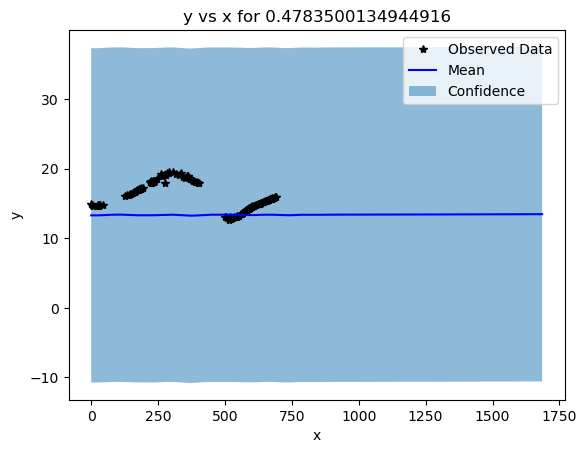

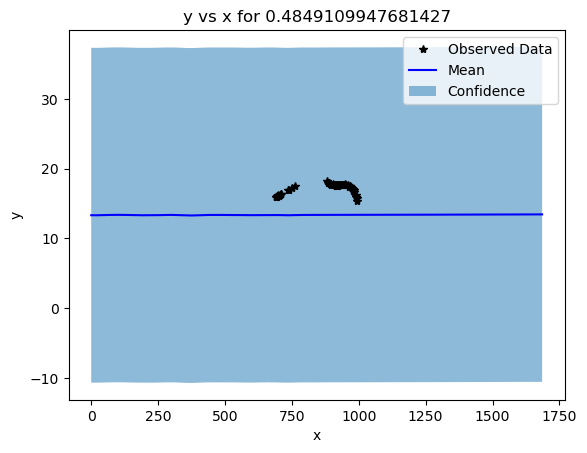

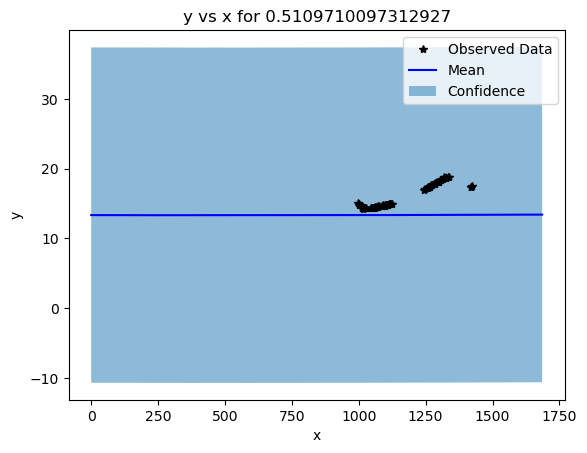

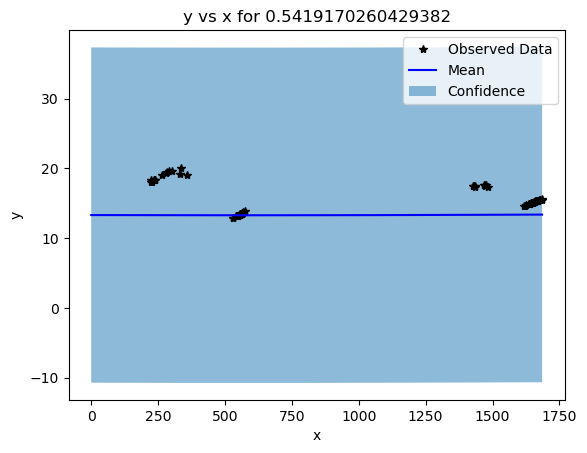

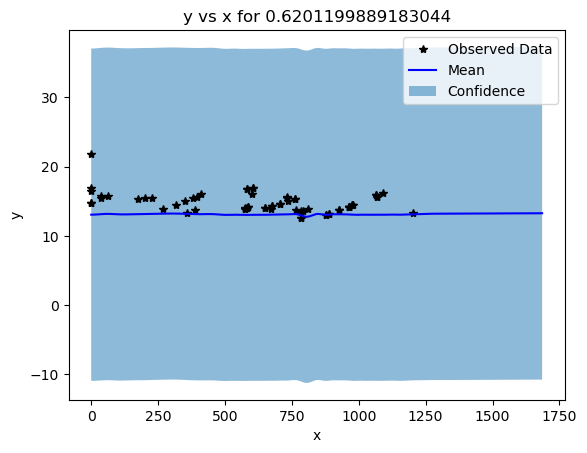

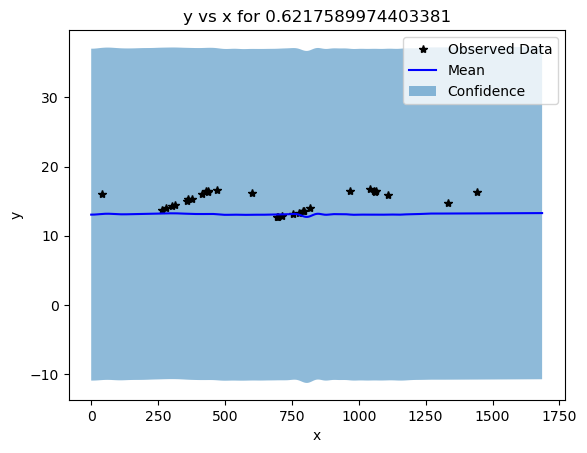

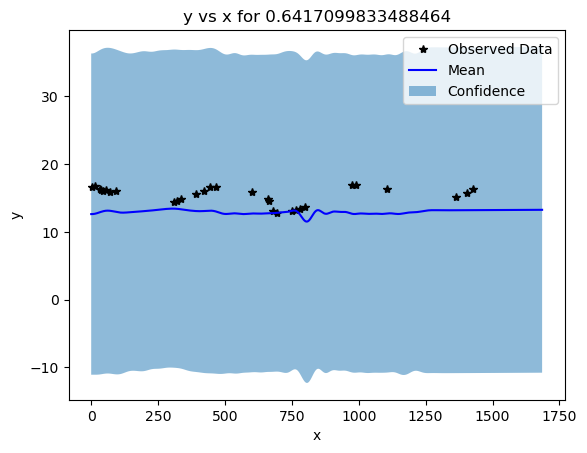

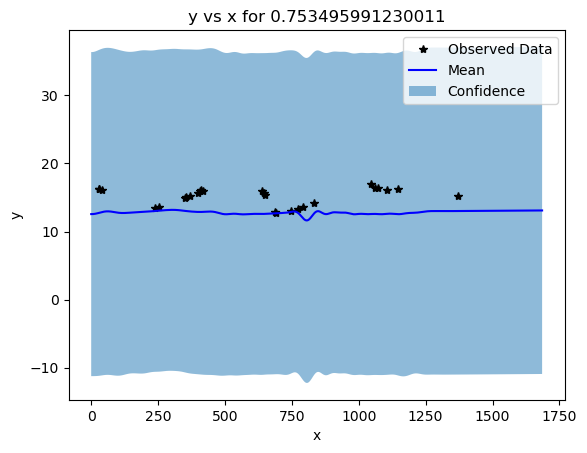

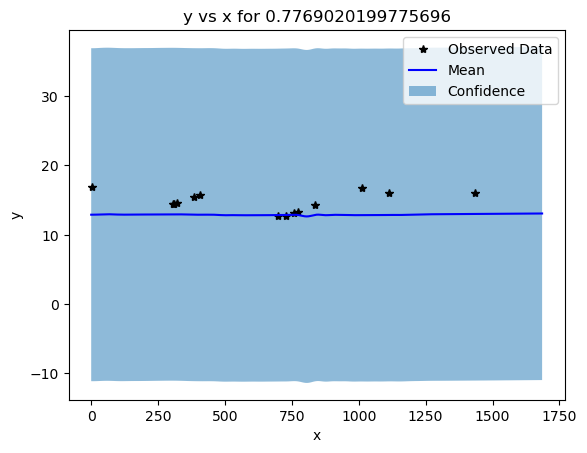

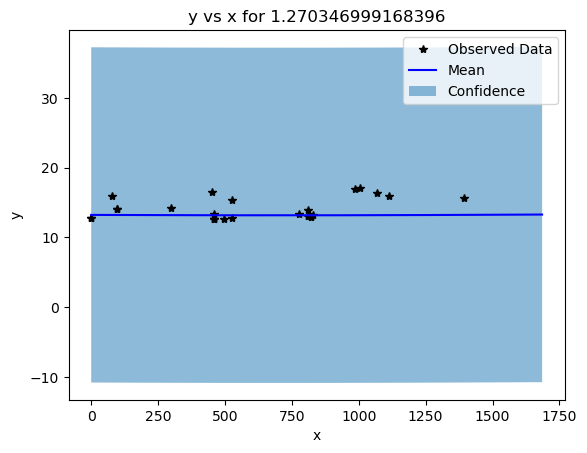

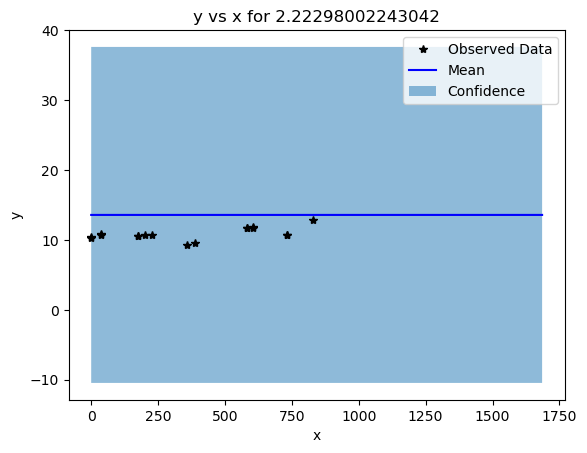

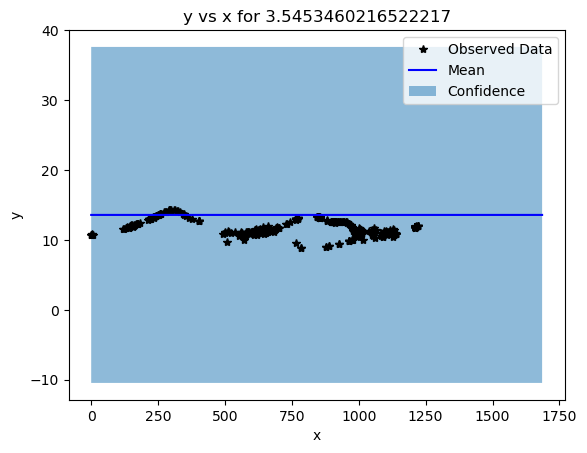

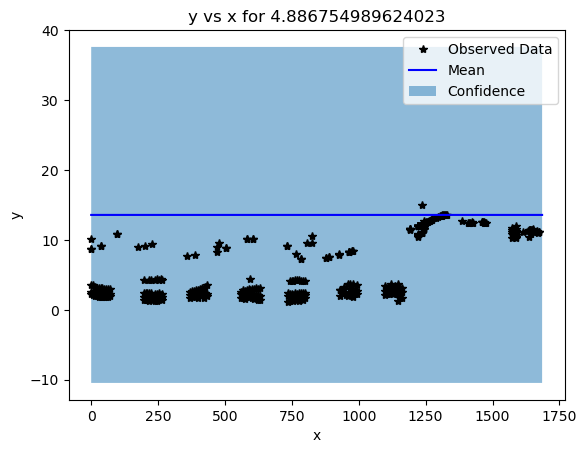

[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

In [23]:
lightcurve2d.plot(ylim=False)